# Sentiment Analysis: Logistic Regression

We will be implementing logistic regression for sentiment analysis on tweets. Given a tweet, we will decide if it has a positive sentiment or a negative one.


Let's first download the necessary datasets.
- ``twitter_samples``: Check out the documentation for the [``twitter_samples`` dataset](http://www.nltk.org/howto/twitter.html).
- ``stopwords``

Uncomment the next cell if you have not downloaded these datasets.


In [1]:
# import nltk
# nltk.download('twitter_samples')
# nltk.download('stopwords')

In [2]:
import re
import string

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import twitter_samples
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

## Prepare the data

The ``twitter_samples`` contains subsets of 5,000 positive tweets, 5,000 negative tweets, and the full set of 10,000 tweets.
- If we used all three datasets, we would introduce duplicates of the positive tweets and negative tweets.
- We will select just the five thousand positive tweets and five thousand negative tweets.


In [3]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

Train test split: 20% will be in the test set, and 80% in the training set.


In [4]:
# split the data into two pieces, one for training and one for testing (validation set) 
train_pos = all_positive_tweets[:4000]
test_pos = all_positive_tweets[4000:]
train_neg = all_negative_tweets[:4000]
test_neg = all_negative_tweets[4000:]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg

Create the numpy array of positive labels and negative labels.


In [5]:
# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

# Print the shape train and test sets
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)


## Preprocessing

Data preprocessing is one of the critical steps in any machine learning project. It includes cleaning and formatting the data before feeding into a machine learning algorithm. For NLP, the preprocessing steps are comprised of the following tasks:
- Tokenizing the string
- Lowercasing
- Removing stop words and punctuation
- Stemming

Since we have a Twitter dataset, we'd like to remove some substrings commonly used on the platform like the hashtag, retweet marks, and hyperlinks.


In [6]:
def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet
    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and     # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

In [7]:
# test the function below
print('\033[0mAn example of a positive tweet: \n\033[34m', train_x[0])
print('\033[0m\nAn example of the processed version of the tweet: \n\033[32m', process_tweet(train_x[0]))
print('\033[0m')

An example of a positive tweet: 
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)

An example of the processed version of the tweet: 
 ['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']



Create the frequency dictionary ``freqs``. The key is the tuple ``(word, label)``, such as ``("happy",1)`` or ``("happy",0)``. The value stored for each key is the count of how many times the word "happy" was associated with a positive label, or how many times "happy" was associated with a negative label.


In [8]:
def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
               frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [9]:
# create frequency dictionary
freqs = build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 11340


## Extracting the features

Given a list of tweets, we extract the features and store them in a matrix. We will extract two features.

- The first feature is the number of positive words in a tweet.
- The second feature is the number of negative words in a tweet.


In [10]:
def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3))
    x[0,0] = 1 #bias term is set to 1
    
    # loop through each word in the list of words
    for word in word_l:
        # increment the word count for the positive label 1
        x[0,1] += freqs.get((word, 1), 0)
        # increment the word count for the negative label 0
        x[0,2] += freqs.get((word, 0), 0)
        
    return x

## Logistic regression: regression and a sigmoid

Logistic regression takes a regular linear regression, and applies a sigmoid to the output of the linear regression.

Regression:

$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$

Note that the $\theta$ values are "weights".

Logistic regression

$$ h(z) = \frac{1}{1+\exp^{-z}}$$
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$

We will refer to 'z' as the 'logits'.


In [11]:
def sigmoid(z): 
    '''
    Input:
        z: is the input (a scalar or an array)
    Output:
        h: the sigmoid of z
    '''
    
    h = 1.0 / (1 + np.exp(-z))
    
    return h

## Cost function and Gradient

The cost function used for logistic regression is the average of the log loss across all training examples:

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)}))$$

- $m$ is the number of training examples
- $y^{(i)}$ is the actual label of the i-th training example.
- $h(z(\theta)^{(i)})$ is the model's prediction for the i-th training example.

### Update the weights

To update our weight vector $\theta$, we will apply gradient descent to iteratively improve our model's predictions.

The gradient of the cost function $J$ with respect to one of the weights $\theta_j$ is:
$$\nabla_{\theta_j}J(\theta) = \frac{1}{m} \sum_{i=1}^m(h^{(i)}-y^{(i)})x_j$$
- 'i' is the index across all 'm' training examples.
- 'j' is the index of the weight $\theta_j$, so $x_j$ is the feature associated with weight $\theta_j$

To update the weight $\theta_j$, we adjust it by subtracting a fraction of the gradient determined by $\alpha$:
$$\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta) $$
- The learning rate $\alpha$ is a value that we choose to control how big a single update will be.

### Vectorization

Instead of updating a single weight $\theta_i$ at a time, we can update all the weights in the column vector:  
$$\mathbf{\theta} = \begin{pmatrix}
\theta_0
\\
\theta_1
\\ 
\theta_2 
\\ 
\vdots
\\ 
\theta_n
\end{pmatrix}$$
- $\mathbf{\theta}$ has dimensions (n+1, 1), where 'n' is the number of features, and there is one more element for the bias term $\theta_0$ (note that the corresponding feature value $\mathbf{x_0}$ is 1).

The 'logits', 'z', are calculated by multiplying the feature matrix 'x' with the weight vector 'theta'.  $z = \mathbf{x}\mathbf{\theta}$
- $\mathbf{x}$ has dimensions (m, n+1) 
- $\mathbf{\theta}$: has dimensions (n+1, 1)
- $\mathbf{z}$: has dimensions (m, 1)

The prediction 'h', is calculated by applying the sigmoid to each element in 'z': $h(z) = sigmoid(z)$, and has dimensions (m,1).

The cost function $J$ is calculated by taking the dot product of the vectors 'y' and 'log(h)'.  Since both 'y' and 'h' are column vectors (m,1), transpose the vector to the left, so that matrix multiplication of a row vector with column vector performs the dot product.
$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)$$

The update of theta is also vectorized.  Because the dimensions of $\mathbf{x}$ are (m, n+1), and both $\mathbf{h}$ and $\mathbf{y}$ are (m, 1), we need to transpose the $\mathbf{x}$ and place it on the left in order to perform matrix multiplication, which then yields the (n+1, 1) answer we need:
$$\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \times \left( \mathbf{x}^T \cdot \left( \mathbf{h-y} \right) \right)$$


In [12]:
def gradient_descent(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations we want to train our model for
    Output:
        J: the final cost
        theta: the final weight vector
    '''
    # get 'm', the number of rows in matrix x
    m = x.shape[0]
    J_list = [] # cost over iteration
    
    for i in range(0, num_iters):
        # get z, the dot product of x and theta
        z = np.dot(x, theta)
        # get the sigmoid of z
        h = sigmoid(z)
        # calculate the cost function
        J = - 1.0 / m * (np.dot(y.T, np.log(h)) + np.dot((1 - y).T, np.log(1 - h)))
        
        # update the weights theta
        theta = theta - alpha / m * np.dot(x.T, h - y)
        
        # add the cost to the list
        J_list.append(float(J))
        
    return float(J), theta, np.array(J_list)

## Training the Model

To train the model, let's stack the features for all training examples into a matrix X and call ``gradient_descent``.


In [13]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

# Alpha: learning rate
alpha = 1e-9

# Number of iterations
n_iter = 1500

# Apply gradient descent
J, theta, J_history = gradient_descent(X, Y, np.zeros((3, 1)), alpha, n_iter)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.24216477.
The resulting vector of weights is [7e-08, 0.0005239, -0.00055517]


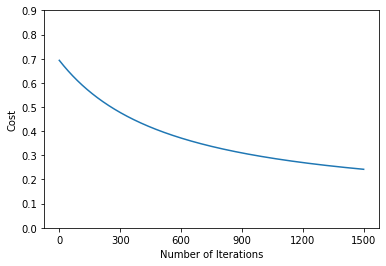

In [14]:
plt.figure()
plt.plot(J_history)
plt.xticks(np.arange(0, n_iter+100, step=300))
plt.yticks(np.arange(0, 1.0, step=0.1))
plt.xlabel("Number of Iterations")
plt.ylabel("Cost")
plt.show()

## Testing the logistic regression

It is time to test the logistic regression function on some new input 
that the model has not seen during the training.

First, we write a function, ``logistic_regression_predict``, that predicts whether 
a tweet is positive or negative.


In [15]:
def logistic_regression_predict(tweet, freqs, theta):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of trained weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''
    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)
    
    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x, theta))
    
    return y_pred

Now, we write a function, ``logistic_regression_evaluate``, that given 
the test data and the weights of our trained model, it calculates 
the accuracy of our logistic regression model.


In [16]:
def logistic_regression_evaluate(test_x, test_y, freqs, theta):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: trained weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
    
    # the list for storing predictions
    y_hat = []
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = logistic_regression_predict(tweet, freqs, theta)
        
        if y_pred >= 0.5:
            y_hat.append(1.0) # append 1.0 to the list
        else:
            y_hat.append(0.0) # append 0.0 to the list

    # With the above implementation, y_hat is a list, but test_y is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    accuracy = np.sum(np.asarray(y_hat).reshape((-1, 1)) == test_y) / test_y.shape[0]
    
    return accuracy

In [17]:
accuracy = logistic_regression_evaluate(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {accuracy:.4f}")

Logistic regression model's accuracy = 0.9950


## Error Analysis

In this part we will see some tweets that our model misclassified. Let's see what kind of tweets does our model misclassify?


In [18]:
# Some error analysis
print('Label Predicted Tweet\n')
for x, y in zip(test_x, test_y):
    y_hat = logistic_regression_predict(x, freqs, theta)

    if np.abs(y - (y_hat >= 0.5)) > 0:
        # print('\033[0mTHE TWEET IS: \033[34m', x)
        # print('\033[0mTHE PROCESSED TWEET IS: \033[32m', process_tweet(x))
        print('\033[31m%d\t%0.8f\t\033[32m%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))

Label Predicted Tweet

1	0.49996897	b'truli later move know queen bee upward bound movingonup'
1	0.48650628	b'sure would good thing 4 bottom dare 2 say 2 miss b im gonna stubborn mouth soap nothavingit :p'
1	0.48370676	b"i'm play brain dot braindot"
1	0.48370676	b"i'm play brain dot braindot"
1	0.48370676	b"i'm play brain dot braindot"
1	0.49578773	b'park get sunlight'
1	0.48199817	b'uff itna miss karhi thi ap :p'
0	0.50020361	b'u prob fun david'
0	0.50039294	b'pat jay'
0	0.50000002	b'belov grandmoth'
